FPL analysis: Who to trade and when?

In this piece of analysis I will be trying to make the best Weekly predictions for an FPL team selection, with the constraints of 1 free transfer.

I will be using a GitHub repository from Vaastav, who kindly updates with raw data each week, for the past few seasons (https://github.com/vaastav/Fantasy-Premier-League)

The data cleaning and prepartion code has helped by Calum Russel (https://github.com/calumrussell/fpl/blob/master/fplpoints_model.ipynb)



In [4]:
##import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import itertools
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [2]:
#its probably easier to import the merged datasets as seperate dataframes

df_2018 =pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2018-19/gws/merged_gw.csv', encoding='iso=8859-1', error_bad_lines=False)
df_2019 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/gws/merged_gw.csv', encoding='iso=8859-1', error_bad_lines=False)
df_2020 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/merged_gw.csv', encoding='iso=8859-1', error_bad_lines=False)
df_2019.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [3]:
player_2019 = pd.read_csv('https://raw.githubusercontent.com/DataJackOH/Fantasy-Premier-League/master/data/2019-20/players_raw.csv', encoding='iso=8859-1', error_bad_lines=False)
player_2020 = pd.read_csv('https://raw.githubusercontent.com/DataJackOH/Fantasy-Premier-League/master/data/2020-21/players_raw.csv', encoding='iso=8859-1', error_bad_lines=False)
player_2019['name']=player_2019['first_name']+player_2019['second_name']
player_2020['name']=player_2020['first_name']+player_2020['second_name']



In [4]:
##fixtures

fixture_2018 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2018-19/fixtures.csv', encoding='iso=8859-1', error_bad_lines=False, parse_dates=['kickoff_time'])
fixture_2019 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/fixtures.csv', encoding='iso=8859-1', error_bad_lines=False,parse_dates=['kickoff_time'])
fixture_2020 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/fixtures.csv', encoding='iso=8859-1', error_bad_lines=False, parse_dates=['kickoff_time'])



In [5]:
##team info 
team_2019 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/teams.csv', encoding='iso=8859-1', error_bad_lines=False)
team_2020 = pd.read_csv('https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/teams.csv', encoding='iso=8859-1', error_bad_lines=False)



In [6]:
##function to keep data we need
def dataClean(players=df_2019, fixtures=fixture_2019, teams=team_2019, players_agg=player_2019):
    players = players[['name','value','fixture','opponent_team','total_points','minutes','transfers_balance','was_home','creativity','influence','bonus','threat']]
    fixtures = fixtures[['id', 'team_a','team_h']]
    teams = teams[['id', 'strength', 'short_name']]
    players_agg = players_agg[['id','element_type']].astype('int64')
    return players, fixtures, teams, players_agg

In [7]:
players, fixtures, teams, players_agg = dataClean(df_2019, fixture_2019, team_2019, player_2019)

In [8]:
players['player_id'] = players['name'].apply(lambda x: x.split("_")[2]).astype('int64')

<ipython-input-8-05301c0ff6f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['player_id'] = players['name'].apply(lambda x: x.split("_")[2]).astype('int64')


In [9]:
#merging fixtures onto players to get fixture information 

##Merging the fixtures onto players so we have information about the match and the player's team and opponent
merged = players.merge(fixtures, how='left', left_on='fixture', right_on='id')

In [10]:
##Merging position onto our players
merged = merged.merge(players_agg, how='left', left_on='player_id', right_on='id' )

In [11]:
##predicition creator being careful only include data that is available before the game.
#create a function to find the most up to date rankings for each team where finished = True
def predictionClean(df, col, name):
    """creates a target column which is the following weeks score, this will be used to build algorithm"""
    shifted = df.groupby('name').shift(-1)
    shifted = pd.DataFrame(shifted[col])
    df_lag = df.join(shifted.rename(columns=lambda x:  name))
    return df_lag

In [13]:
 #create a function to add form and class to each column, then impute the means
def formAndClass(df, form_window=4, class_window=10):
    """This function creates 'FORM' columns, based on the last 4 games for a player
    Default values are 4 for form and 10 weeks for class."""
    
    df['Form'] = df.groupby(['name']).rolling(form_window)['total_points'].mean().reset_index(level=[0,1],drop=True)
    df['CreativityForm'] = df.groupby(['name']).rolling(form_window)['creativity'].mean().reset_index(level=[0,1],drop=True)
    
    df['InfluenceForm'] = df.groupby(['name']).rolling(form_window)['influence'].mean().reset_index(level=[0,1],drop=True)
    df['ThreatForm'] = df.groupby(['name']).rolling(form_window)['threat'].mean().reset_index(level=[0,1],drop=True)
    df['MinutesAVG'] = df.groupby(['name']).rolling(form_window)['minutes'].mean().reset_index(level=[0,1],drop=True)
    
    ##impute the mean for each class form pairing
    df['Form'] = df['Form'].fillna(df.groupby('name')['Form'].transform('mean'))
    df['MinutesAVG'] = df['MinutesAVG'].fillna(df.groupby('name')['MinutesAVG'].transform('mean'))
    df['CreativityForm'] = df['CreativityForm'].fillna(df.groupby('name')['CreativityForm'].transform('mean'))
    df['ThreatForm'] = df['ThreatForm'].fillna(df.groupby('name')['ThreatForm'].transform('mean'))
    df['InfluenceForm'] = df['InfluenceForm'].fillna(df.groupby('name')['InfluenceForm'].transform('mean'))
    
    return df

In [14]:
##Create a row for the player's team
merged['team'] = np.where(merged['opponent_team'] == merged['team_a'], merged['team_h'], merged['team_a'])
##Create a row for player team difficulty
merged = merged.merge(teams, how='left', left_on='team', right_on='id')
merged.rename(columns={'strength': 'team_diff', 'short_name': 'team_short'}, inplace=True)
##Create a row for opponent team difficulty
merged = merged.merge(teams, how='left', left_on='opponent_team', right_on='id')
merged.rename(columns={'strength': 'opp_diff', 'short_name': 'opp_short'}, inplace=True)
##Create a row for difficulty difference
merged['diff_diff'] = merged['team_diff'] - merged['opp_diff']

In [15]:
merged = formAndClass(merged)

In [16]:
##convert home to int boolean
merged['is_home'] = merged['was_home'].astype(int)

In [17]:
merged.head()

,name,value,fixture,opponent_team,total_points,minutes,transfers_balance,was_home,creativity,influence,...,id_y,opp_diff,opp_short,diff_diff,Form,CreativityForm,InfluenceForm,ThreatForm,MinutesAVG,is_home
0,Aaron_Cresswell_376,50,8,11,0,90,0,True,1.5,9.0,...,11,5,MCI,-3,1.195312,5.232031,6.529688,3.109375,31.460938,1
1,Aaron_Lennon_430,50,3,16,1,6,0,True,0.0,2.0,...,16,3,SOU,0,1.185714,4.010714,7.067143,4.457143,31.742857,1
2,Aaron_Mooy_516,50,7,18,0,0,0,False,0.0,0.0,...,18,3,WAT,-1,1.411765,5.436765,8.377941,7.338235,34.823529,0
3,Aaron_Ramsdale_494,45,2,15,2,90,0,True,0.0,9.8,...,15,3,SHU,-1,1.000000,1.450000,0.850000,9.750000,18.750000,1
4,Aaron_Wan-Bissaka_122,55,9,6,8,90,0,True,16.1,30.4,...,6,4,CHE,0,4.000000,7.375000,18.350000,36.500000,32.500000,1


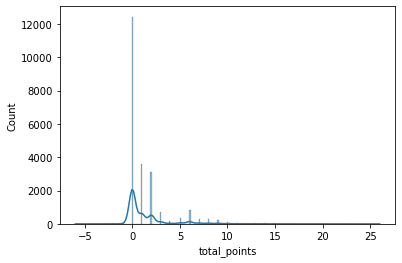

In [18]:
##lets see how skewed total points is, as our target variables
sns.histplot(data=merged, x='total_points', kde=True)

the code is massively right skewed, with some negative variables, which makes it a good candidate for a log transformation for the linear regression

In [19]:
cleaned = merged.copy(deep=True)

cleaned.loc[cleaned['total_points'] < 0, 'total_points'] = 0
cleaned['total_points'] = (cleaned['total_points'] + 1).astype('float32')
cleaned['log_points'] = np.log(cleaned['total_points'])

cleaned = cleaned.drop(cleaned[cleaned.minutes == 0].index)

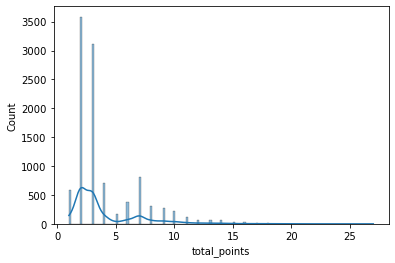

In [20]:
sns.histplot(data=cleaned, x='total_points', kde=True)

In [21]:
cleaned.isnull().sum()

name                 0
value                0
fixture              0
opponent_team        0
total_points         0
minutes              0
transfers_balance    0
was_home             0
creativity           0
influence            0
bonus                0
threat               0
player_id            0
id_x                 0
team_a               0
team_h               0
id_y                 0
element_type         0
team                 0
id_x                 0
team_diff            0
team_short           0
id_y                 0
opp_diff             0
opp_short            0
diff_diff            0
Form                 0
CreativityForm       0
InfluenceForm        0
ThreatForm           0
MinutesAVG           0
is_home              0
log_points           0
dtype: int64

In [22]:
##pull in next game info, i.e. difficulty, whether at home, target points.
cleaned = predictionClean(cleaned,'opp_diff', 'next_opp_diff')
cleaned = predictionClean(cleaned,'opp_short', 'next_opp')
cleaned = predictionClean(cleaned,'diff_diff', 'next_diff_diff')
cleaned = predictionClean(cleaned,'log_points', 'target_next_points_log')
cleaned = predictionClean(cleaned,'total_points', 'target_next_points')
cleaned = predictionClean(cleaned,'is_home', 'next_is_home')

In [23]:
#drop the null prediction column
cleaned = cleaned.dropna(subset=['target_next_points'])

In [24]:
##limit to only data we will have prior to kick off 
#split into X and Y
X = cleaned[['value','CreativityForm','InfluenceForm','ThreatForm','MinutesAVG','Form','next_opp_diff','next_diff_diff']].astype('float64')
Y = cleaned['target_next_points'].astype('float64')

In [25]:
##split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.33)

In [26]:
##make model pipeline 
model = LinearRegression().fit(X_train, y_train)


In [27]:
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)


coefficient of determination: 0.059490170912679385
intercept: 2.526609048063414


R2 isn't great, maybe we should try a different approach, potentially adding in xG and xA variables.


In [1]:
import asyncio
import json

import aiohttp

from understat import Understat
import nest_asyncio
nest_asyncio.apply()
import os
import html

In [2]:
async def get_data(league, year):
    int_stats = ["goals", "shots", "time", "assists", "key_passes", "npg"]
    float_stats = ["xG", "xA", "npxG", "xGChain", "xGBuildup"]
    stats = int_stats + float_stats

    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        t = await understat.get_teams(league, year)
        max_fixtures = max(len(x["history"]) for x in t)
        teams = [x["title"] for x in t]
        data = []

        for team in teams:
            fixtures = await understat.get_team_results(team, year)
            fixture_ids = [x["id"] for x in fixtures]
            players = await understat.get_team_players(team, year)
            for player in players:
                y = await understat.get_player_matches(player["id"], season=str(year))
                p_matches = [x["id"] for x in y]

                statData = [["-"] * max_fixtures for _ in range(len(stats))]
                for i, ID in enumerate(p_matches):
                    try:
                        for j, stat in enumerate(stats):
                            if stat in int_stats:
                                statData[j][fixture_ids.index(ID)] = int(y[i][stat])
                            else:
                                statData[j][fixture_ids.index(ID)] = round(float(y[i][stat]), 4)
                    except:
                        pass

                data.append(
                    [
                        [player["id"], html.unescape(player["player_name"]), player["team_title"]] +
                        statData[i] +
                        [round(sum(x for x in statData[i] if x != "-"), 4)]
                        for i in range(len(statData))
                    ]
                )

        outdir = f"/Users/jackohagan/Documents/FPL/player/{str(year)}-{str(year + 1)[2:]}/{league}"
        if not os.path.exists(outdir):
            os.mkdir(outdir)

        for i, stat in enumerate(stats):
            df = pd.DataFrame(
                [data[x][i] for x in range(len(data))],
                columns=["id", "name", "team"] +
                list(range(1, max_fixtures + 1)) +
                ["total"]
            )

            df = df.sort_values(by="total", ascending=False)

            df.to_csv(
                f"/Users/jackohagan/Documents/FPL/player/{str(year)}-{str(year + 1)[2:]}/{league}-{stat}.csv",
                index=False
            )


In [5]:


async def main():
    leagues = ["EPL"]
    # leagues = ["EPL", "La Liga", "Bundesliga", "Serie A"]
    return await asyncio.gather(*[get_data(l, 2020) for l in leagues])

if __name__ == "__main__":
    asyncio.get_event_loop().run_until_complete(main())